<a href="https://colab.research.google.com/github/nhtlongcs/VinBigData-Abnormalities-Detection/blob/ffyytt-fasterrcnn/2021_VINBIGDATA_FASTER_RCNN_ADAS_FOLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Mar  6 08:07:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import json
token = {"username":"duonganhkiet","key":"c7b0eb66e2722030c850b9ea619a3fb0"}
!mkdir -p '/root/.kaggle/'
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -qq map-boxes
!pip install -qq ensemble_boxes
!pip install -qq git+https://github.com/albumentations-team/albumentations
!git clone https://github.com/facebookresearch/detr.git

     |████████████████████████████████| 952kB 4.2MB/s 
Cloning into 'detr'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 12.84 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [ ]:
import os
import cv2
import copy
import time
import random
import zipfile
import numpy as np
import pandas as pd
import multiprocessing

from tqdm import *
from glob import glob
from matplotlib import pyplot as plt
from collections import Counter

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

from ensemble_boxes import *
from map_boxes import mean_average_precision_for_boxes
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /usr/local/lib/python3.7/dist-packages/map_boxes/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [ ]:
if not os.path.exists('data/vinbigdata/'):
    os.makedirs('data/vinbigdata/')
    !kaggle datasets download -d duonganhkiet/2021-vin-mydataset
    !unzip -q 2021-vin-mydataset.zip -d data/vinbigdata

  0% 0.00/2.15M [00:00<?, ?B/s]
100% 2.15M/2.15M [00:00<00:00, 150MB/s]


In [ ]:
FOLD = 0
config = {
    'fold': FOLD,
    'image_paths':'data/vinbigdata/train/',
    'imgSize': 2048,
    'num_classes': 15,
    'no_finding_sample': 5000,
    'seed': 1312,
    'device': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    'iou_thr':0.5,
    'infer_iou_thr': 0.99,
    'skip_box_thr':0.01,
    'lr' : 1e-4,
    'batch_size': 4,
    'iter_size': 8,
    'save_dir': 'gdrive/MyDrive/2021_VINBIGDATA/NEW_FOLD/FRCNN/FOLD'+str(FOLD),
    'WEIGHT_PATH': None,
    'weight_epoch': 0,
    'n_epochs': 400,
    'scheduler': False,
    'valid_scheduler': True,
    'debug': False,
    'gt': 'nms512_fold'+str(FOLD)+'_val.json'
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(config['seed'])

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
df = pd.read_csv('data/vinbigdata/train.csv')

df['x_min'] = np.where(df['x_min'].isnull(), 0, df['x_min'])
df['x_max'] = np.where(df['x_max'].isnull(), 1, df['x_max'])
df['y_min'] = np.where(df['y_min'].isnull(), 0, df['y_min'])
df['y_max'] = np.where(df['y_max'].isnull(), 1, df['y_max'])

df['area'] = (df['x_max']-df['x_min'])*(df['y_max']-df['y_min'])

df['class_id'] += 1

if (config['num_classes'] == 15):
    df = df[df['class_name'] != 'No finding'].append(df[df['class_name'] == 'No finding'].sample(config['no_finding_sample']), ignore_index=True)
    df.loc[df["class_id"] == 15, ["class_id"]] = 0

    
df["class_id"] = df["class_id"]
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,fold,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R10,691.0,1375.0,1653.0,1831.0,2080,2336,2,438672.0
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,1,R10,1264.0,743.0,1611.0,1019.0,2304,2880,0,95772.0
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,12,R9,627.0,357.0,947.0,433.0,2540,3072,1,24320.0
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,6,R17,1347.0,245.0,2188.0,2169.0,2285,2555,3,1618084.0
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,9,R9,557.0,2352.0,675.0,2484.0,2568,3353,1,15576.0


In [ ]:
image_ids = df['image_id'].unique()
train_ids = df['image_id'][df['fold'] != config['fold']].unique()
valid_ids = df['image_id'][df['fold'] == config['fold']].unique()
print(len(train_ids), len(valid_ids))
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]

6918 1722


In [ ]:
if not os.path.exists(config['image_paths']):
    !gdown --id 1y4wV9T_ITyG8hz5OE3cUhtVqEP14cEx4
    !kaggle datasets download -d corochann/vinbigdata-chest-xray-original-png
    os.makedirs(config['image_paths'])
    with zipfile.ZipFile('vinbigdata-chest-xray-original-png.zip') as z:
        for filename in tqdm(image_ids):
            with open(config['image_paths']+filename+'.png', 'wb+') as f:
                f.write(z.read('train/'+filename+'.png'))

Downloading...
From: https://drive.google.com/uc?id=1y4wV9T_ITyG8hz5OE3cUhtVqEP14cEx4
To: /content/nms512_fold0_val.json
100% 808k/808k [00:00<00:00, 48.5MB/s]
100% 46.5G/46.5G [15:17<00:00, 70.5MB/s]
100% 46.5G/46.5G [15:17<00:00, 54.4MB/s]


100%|██████████| 8640/8640 [08:02<00:00, 17.91it/s]


In [ ]:
def get_train_transforms():
    return A.Compose(
        [
         A.OneOf([
            A.MotionBlur(p=.2),
            A.GaussianBlur(),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.1)
         ], p=0.3),
         
         A.OneOf([
            A.HorizontalFlip(p=1.0),
            A.VerticalFlip(p=1.0),
            A.RandomRotate90(p=1.0),
            A.Transpose(p=0.5),
         ], p=0.5),

         A.OneOf([
            # A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
            #                      val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.1, 
                                       contrast_limit=0.1, 
                                       p=0.3),            
         ], p=0.5),
         
         A.OneOf([ 
            A.Cutout(num_holes=1, max_h_size=4, max_w_size=4, fill_value=0, p=1.0),
            A.Cutout(num_holes=2, max_h_size=2, max_w_size=2, fill_value=0, p=1.0),
         ], p = 0.01),

         A.JpegCompression(quality_lower=80, quality_upper=95, p=0.02),
         A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
         A.Resize(height=800, width=800, p=0.01),
         ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
         ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [ ]:
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_dir, transforms=None, test=False):
        super().__init__()

        self.image_ids = marking["image_id"].unique()
        self.image_dir = image_dir
        self.marking = marking
        self.transforms = transforms
        self.test = test
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if (random.random() > 0.5): #50%
            image, boxes, labels = self.load_image_and_boxes(index)
        else:
            if (random.random() > 0.5): #25%
                image, boxes, labels = self.load_mixup_image_and_boxes(index)
            else:
                image, boxes, labels = self.load_resize_image_and_boxes(index)

        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            while True:
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    break

        return image, target, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]

        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
            
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        labels = records['class_id'].values

        return image, boxes, labels

    def load_resize_image_and_boxes(self, index):
        image_id = self.image_ids[index]

        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        h,w,_  = image.shape
        image = cv2.resize(image, (config['imgSize'], config['imgSize'])) 
            
        records = self.marking[self.marking['image_id'] == image_id]
        labels = records['class_id'].values
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values

        if (labels[0] != 0):
            boxes[:,0]*= (config['imgSize']/w)
            boxes[:,1]*= (config['imgSize']/h)
            boxes[:,2]*= (config['imgSize']/w)
            boxes[:,3]*= (config['imgSize']/h)
        

        return image, boxes, labels

    def load_mixup_image_and_boxes(self, index):
        image, boxes, labels = self.load_resize_image_and_boxes(index)
        r_image, r_boxes, r_labels = self.load_resize_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1))
        return (image+r_image)/2, np.vstack((boxes, r_boxes)).astype(np.int32), np.concatenate((labels, r_labels))
    
    def load_cutmix_image_and_boxes(self, index, imsize=(config['imgSize'], config['imgSize'])):
        w,h = imsize
        xc, yc = [int(random.uniform( h * 0.75, w * 0.25)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((h, w, 3), 1, dtype=np.float32)
        result_boxes = []
        result_labels = np.array([], dtype=np.int)
        
        for i, index in enumerate(indexes):
            image, boxes, labels = self.load_resize_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, w), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(h, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, w), min(h, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h) 

            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b
            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)
            result_labels = np.concatenate((result_labels, labels))

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0], 0, w, out=result_boxes[:, 0])
        np.clip(result_boxes[:, 2], 0, w, out=result_boxes[:, 2])
        np.clip(result_boxes[:, 3], 0, h, out=result_boxes[:, 3])
        np.clip(result_boxes[:, 1], 0, h, out=result_boxes[:, 1])

        result_boxes = result_boxes.astype(np.int32)
        index_to_use = np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)
        result_boxes = result_boxes[index_to_use]
        result_labels = result_labels[index_to_use]
        return result_image, result_boxes, result_labels

In [ ]:
train_dataset = DatasetRetriever(
    marking=train_df,
    image_dir=config['image_paths'],
    transforms=get_train_transforms(),
    test = False
)

validation_dataset = DatasetRetriever(
    marking=valid_df,
    image_dir=config['image_paths'],
    transforms=get_valid_transforms(),
    test = True
)

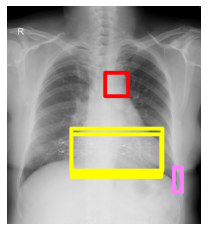

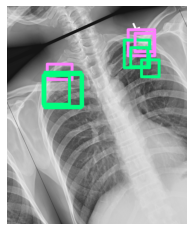

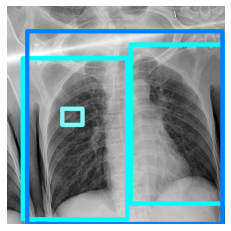

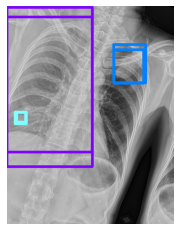

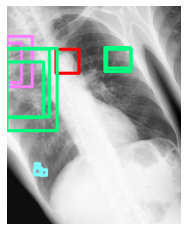

In [ ]:
mapping = {0: (1,0,0), 1: (0,1,0), 2: (0,0,1), 3: (1,1,0), 
           4: (1,0,1), 5: (0,1,1), 6: (0.5,1,0), 7: (0.5,0,1), 
           8: (0.5,1,1), 9: (0,0.5,1), 10: (1,0.5,0), 11: (1,0.5,1),
           12: (1,0,0.5), 13: (0,1,0.5), 14: (1,1,0.5)}

for i in range(5):
    image, target, image_id = train_dataset[i]
    boxes = target['boxes'].cpu().numpy().astype(np.int64)
    labels = target['labels'].cpu().numpy()

    numpy_image = image.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    for box, label in zip(boxes, labels):
        if (label == 0):
            continue
        cv2.rectangle(numpy_image, (box[0], box[1]), (box[2], box[3]), mapping[label-1], 40)

    ax.set_axis_off()
    ax.imshow(numpy_image)
    plt.show()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import math
import torch
from torch.optim import Optimizer

class Adas(Optimizer):
    r"""
    Introduction:
        For the mathematical part see https://github.com/YanaiEliyahu/AdasOptimizer,
        the `Theory` section contains the major innovation,
        and then `How ADAS works` contains more low level details that are still somewhat related to the theory.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining parameter groups
        lr: float > 0. Initial learning rate that is per feature/input (e.g. dense layer with N inputs and M outputs, will have N learning rates).
        lr2: float >= 0.  lr's Initial learning rate. (just ~1-2 per layer, additonal one because of bias)
        lr3: float >= 0. lr2's fixed learning rate. (global)
        beta_1: 0 < float < 1. Preferably close to 1. Second moments decay factor to update lr and lr2 weights.
        beta_2: 0 < float < 1. Preferably close to 1. 1/(1 - beta_2) steps back in time that `lr`s will be optimized for, larger dataset might require more nines.
        beta_3: 0 < float < 1. Preferably close to 1. Same as beta_2, but for `lr2`s.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
    """

    def __init__(self, params,
            lr = 0.001, lr2 = .005, lr3 = .0005,
            beta_1 = 0.999, beta_2 = 0.999, beta_3 = 0.9999,
            epsilon = 1e-8, **kwargs):
        if not 0.0 <= lr:
            raise ValueError("Invalid lr: {}".format(lr))
        if not 0.0 <= lr2:
            raise ValueError("Invalid lr2: {}".format(lr))
        if not 0.0 <= lr3:
            raise ValueError("Invalid lr3: {}".format(lr))
        if not 0.0 <= epsilon:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta_1 < 1.0:
            raise ValueError("Invalid beta_1 parameter: {}".format(betas[0]))
        if not 0.0 <= beta_2 < 1.0:
            raise ValueError("Invalid beta_2 parameter: {}".format(betas[1]))
        if not 0.0 <= beta_3 < 1.0:
            raise ValueError("Invalid beta_3 parameter: {}".format(betas[2]))
        defaults = dict(lr=lr, lr2=lr2, lr3=lr3, beta_1=beta_1, beta_2=beta_2, beta_3=beta_3, epsilon=epsilon)
        self._varn = None
        self._is_create_slots = None
        self._curr_var = None
        self._lr = lr
        self._lr2 = lr2
        self._lr3 = lr3
        self._beta_1 = beta_1
        self._beta_2 = beta_2
        self._beta_3 = beta_3
        self._epsilon = epsilon
        super(Adas, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adas, self).__setstate__(state)

    @torch.no_grad()
    def _add(self,x,y):
        x.add_(y)
        return x

    @torch.no_grad()
    # TODO: fix variables' names being too convoluted in _derivatives_normalizer and _get_updates_universal_impl
    def _derivatives_normalizer(self,derivative,beta):
        steps = self._make_variable(0,(),derivative.dtype)
        self._add(steps,1)
        factor = (1. - (self._beta_1 ** steps)).sqrt()
        m = self._make_variable(0,derivative.shape,derivative.dtype)
        moments = self._make_variable(0,derivative.shape,derivative.dtype)
        m.mul_(self._beta_1).add_((1 - self._beta_1) * derivative * derivative)
        np_t = derivative * factor / (m.sqrt() + self._epsilon)
        #the third returned value should be called when the moments is finally unused, so it's updated
        return (moments,np_t,lambda: moments.mul_(beta).add_((1 - beta) * np_t))

    def _make_variable(self,value,shape,dtype):
        self._varn += 1
        name = 'unnamed_variable' + str(self._varn)
        if self._is_create_slots:
            self.state[self._curr_var][name] = torch.full(size=shape,fill_value=value,dtype=dtype,device=self._curr_var.device)
        return self.state[self._curr_var][name]

    @torch.no_grad()
    def _get_updates_universal_impl(self, grad, param):
        lr = self._make_variable(value = self._lr,shape=param.shape[1:], dtype=param.dtype)
        moment, deriv, f = self._derivatives_normalizer(grad,self._beta_3)
        param.add_( - torch.unsqueeze(lr,0) * deriv)
        lr_deriv = torch.sum(moment * grad,0)
        f()
        master_lr = self._make_variable(self._lr2,(),dtype=torch.float32)
        m2,d2, f = self._derivatives_normalizer(lr_deriv,self._beta_2)
        self._add(lr,master_lr * lr * d2)
        master_lr_deriv2 = torch.sum(m2 * lr_deriv)
        f()
        m3,d3,f = self._derivatives_normalizer(master_lr_deriv2,0.)
        self._add(master_lr,self._lr3 * master_lr * d3)
        f()

    @torch.no_grad()
    def _get_updates_universal(self, param, grad, is_create_slots):
        self._curr_var = param
        self._is_create_slots = is_create_slots
        self._varn = 0
        return self._get_updates_universal_impl(grad,self._curr_var.data)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adas does not support sparse gradients')
                self._get_updates_universal(p,grad,len(self.state[p]) == 0)
        return loss

In [ ]:
class mAPScore:
    def __init__(self, gt_json, pred_json):
        self.gt_json = gt_json
        self.pred_json = pred_json
        self.coco_gt = COCO(gt_json)
        self.get_image_ids()

    def get_image_ids(self):
        self.image_ids = []
        with open(self.pred_json, 'r') as f:
            data = json.load(f)
            for item in data:
                image_id = item['image_id']
                self.image_ids.append(image_id)

    def evaluate(self):
        coco_pred = self.coco_gt.loadRes(self.pred_json)

        coco_eval = COCOeval(self.coco_gt, coco_pred, 'bbox')
        coco_eval.params.imgIds = self.image_ids

        coco_eval.params.iouThrs = np.array([0.4])

        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        stats = coco_eval.stats
        return stats

In [ ]:
def to_format(image_id, boxes, scores, labels):
    result = [0]*len(labels)
    boxes = boxes.tolist()
    labels = labels.tolist()
    scores = scores.tolist()
    for i in range(len(labels)):
        result[i] = {
            'image_id': image_id,
            'category_id': labels[i],
            'score': scores[i],
            'bbox': [boxes[i][0], boxes[i][1], boxes[i][2]-boxes[i][0], boxes[i][3]-boxes[i][1]]
        }
    return result

image_name_to_id = {}
with open(config['gt']) as json_file:
    data = json.load(json_file)['images']
    for i in data:
        image_name_to_id[i['file_name']] = i['id']

def mAP(df, gt, iou = config['iou_thr']):

    df = np.array([
                   df['ImageID'],
                   np.array(df['LabelName']).astype(np.int32),
                   df['Conf'],
                   df['XMin'],
                   df['YMin'],
                   df['XMax'],
                   df['YMax']
                   ]).T
    
    gt = np.array([
                   gt['ImageID'],
                   np.array(gt['LabelName']).astype(np.int32),
                   gt['XMin'],
                   gt['YMin'],
                   gt['XMax'],
                   gt['YMax']
                   ]).T
    
    return mean_average_precision_for_boxes(gt,
                                            df,
                                            iou_threshold = iou, verbose = True)

In [ ]:
class Fitter:
    def __init__(self,
                 model,
                 optimizer,
                 lr_scheduler,
                 valid_scheduler,
                 debug = 100):
        
        self.epoch = config['weight_epoch']

        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = model
        self.model.to(self.device)

        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.valid_scheduler = valid_scheduler

        self.debug = debug

        if not os.path.exists(config['save_dir']):
            os.makedirs(config['save_dir'])

    def fit(self, train_loader, valid_loader, n_epochs, debug = False):
        for e in range(config['weight_epoch'], n_epochs):
            print('EPOCH:',e,'LR:',self.optimizer.param_groups[0]['lr'])
            t = time.time()
            summary_loss = self.train_one_epoch(train_loader, debug)

            self.model.eval()
            torch.save(self.model.state_dict(), config['save_dir']+f"/model_state_epoch_{str(self.epoch).zfill(3)}.pth")

            t = time.time()
            mAP04 = self.validation(valid_loader, debug)[0]

            if (config['valid_scheduler']):
                self.valid_scheduler.step(metrics=mAP04)

            self.epoch += 1

    def train_one_epoch(self, train_loader, debug):
        self.model.train()
        summary_loss = AverageMeter()
        self.optimizer.zero_grad()
        
        step = 0
        loss_mini_batch = 0

        train_stt = tqdm(train_loader)
        for step, (images, targets, image_ids) in enumerate(train_stt):
            if (step%config['iter_size'] != 0):
                train_stt.set_description(f"Loss: {summary_loss.avg:.5f}, Loss batch: {(loss_mini_batch/(step%config['iter_size'])):.5f}")
            else:
                train_stt.set_description(f"Loss: {summary_loss.avg:.5f}, Loss batch: 0.00000")
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = self.model(images, targets)
            losses = sum(loss for loss in loss_dict.values()) + loss_dict['loss_rpn_box_reg'] + loss_dict['loss_box_reg']
            loss_mini_batch += losses.item()

            losses.backward()

            if (step+1) % config['iter_size'] == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()
                loss_mini_batch = 0
                if (config['scheduler']):
                    self.lr_scheduler.step()

            summary_loss.update(losses.item(), len(images))

            step += 1
            if (debug):
                if (step > self.debug):
                    break

    def validation(self, valid_loader, debug):
        self.model.eval()
        valid_stt = tqdm(valid_loader)
        json_data = []
        df = {'ImageID': [], 'LabelName': [], 'Conf':[], 'XMin': [], 'XMax': [], 'YMin': [], 'YMax': []}
        gt = {'ImageID': [], 'LabelName': [], 'XMin': [], 'XMax': [], 'YMin': [], 'YMax': []}

        with torch.no_grad():
            for step, (images, targets, image_ids) in enumerate(valid_stt):
                valid_stt.set_description(f"Num boxes: {len(df['ImageID'])}")

                images = list(image.to(device) for image in images)
                batch_size = len(images)
                pred = self.model(images)

                for i in range(batch_size):
                    _, h,w = images[i].cpu().detach().numpy().shape

                    boxes  = pred[i]['boxes'].cpu().detach().numpy()
                    labels =  pred[i]['labels'].cpu().detach().numpy()
                    scores =  pred[i]['scores'].cpu().detach().numpy()

                    boxes[:, 0] = (boxes[:, 0] / w)
                    boxes[:, 1] = (boxes[:, 1] / h)
                    boxes[:, 2] = (boxes[:, 2] / w)
                    boxes[:, 3] = (boxes[:, 3] / h)

                    target_boxes = targets[i]['boxes'].cpu().detach().numpy()
                    target_labels = targets[i]['labels'].cpu().detach().numpy()

                    target_boxes[:, 0] = (target_boxes[:, 0] / w)
                    target_boxes[:, 1] = (target_boxes[:, 1] / h)
                    target_boxes[:, 2] = (target_boxes[:, 2] / w)
                    target_boxes[:, 3] = (target_boxes[:, 3] / h)

                    
                    boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels],
                                                                weights=None,
                                                                iou_thr=config['infer_iou_thr'],
                                                                skip_box_thr=config['skip_box_thr'])
                    
                    
                    labels = labels.astype(np.int32)
                    target_labels = target_labels.astype(np.int32)
                    

                    df['ImageID'] += [image_ids[i]]*len(boxes)
                    df['LabelName'] += labels.tolist()
                    df['Conf'] += scores.tolist()
                    df['XMin'] += boxes[:,0].tolist()
                    df['YMin'] += boxes[:,1].tolist()
                    df['XMax'] += boxes[:,2].tolist()
                    df['YMax'] += boxes[:,3].tolist()

                    gt['ImageID'] += [image_ids[i]]*len(target_boxes)
                    gt['LabelName'] += target_labels.tolist()
                    gt['XMin'] += target_boxes[:,0].tolist()
                    gt['YMin'] += target_boxes[:,1].tolist()
                    gt['XMax'] += target_boxes[:,2].tolist()
                    gt['YMax'] += target_boxes[:,3].tolist()

                    #json_data += to_format(image_name_to_id[image_ids[i]+'.png'], boxes*512, scores, labels-1)

                step += 1
                if (debug):
                    if (step > self.debug):
                        break

            mAP04 = mAP(df, gt, 0.4)

            if (len(json_data) > 0):
                with open('eval.json', 'w') as f:
                    json.dump(json_data, f)

                #mAPScore(config['gt'], 'eval.json').evaluate()
            
        return mAP04

In [ ]:
def load_net(pretrained=False, progress=True,
             num_classes=config['num_classes'], pretrained_backbone=True,
             trainable_backbone_layers=5,  **kwargs):
    assert trainable_backbone_layers <= 5 and trainable_backbone_layers >= 0
    # dont freeze any layers if pretrained model or backbone is not used
    if not (pretrained or pretrained_backbone):
        trainable_backbone_layers = 5
    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    backbone = resnet_fpn_backbone('resnet152', pretrained_backbone, trainable_layers=trainable_backbone_layers)
    model = FasterRCNN(backbone, num_classes, **kwargs)
    model.to(config['device'])

    return model

net = load_net()
if (config['WEIGHT_PATH']):
    net.load_state_dict(torch.load(config['WEIGHT_PATH'], map_location=config['device']))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training(debug = False):
    
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        sampler=RandomSampler(train_dataset),
        pin_memory=True,
        drop_last=True,
        num_workers=multiprocessing.cpu_count(),
        collate_fn=collate_fn,
    )
    
    valid_data_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=config['batch_size'],
        num_workers=multiprocessing.cpu_count(),
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=True,
        collate_fn=collate_fn,
    )

    optimizer = Adas([p for p in net.parameters() if p.requires_grad], lr=config['lr'])
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                T_0=100,
                                                                T_mult=1,
                                                                eta_min=0.0001,
                                                                last_epoch=-1,
                                                                verbose = False)
    
    valid_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

    fitter = Fitter(model = net, optimizer = optimizer, lr_scheduler = lr_scheduler, valid_scheduler = valid_scheduler)
    fitter.fit(train_data_loader, valid_data_loader, n_epochs = config['n_epochs'], debug = debug)

In [ ]:
run_training(config['debug'])

  0%|          | 0/1729 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.0001


Num boxes: 26909: 100%|██████████| 431/431 [07:44<00:00,  1.08s/it]


Number of files in annotations: 1722
Number of files in predictions: 1655
Unique classes: 15
Detections length: 1655
Annotations length: 1722
0                              | 0.000000 |    1239
1                              | 0.000000 |    1832
10                             | 0.000000 |     523
11                             | 0.000000 |     603
12                             | 0.000000 |    1180
13                             | 0.000000 |      43
14                             | 0.000000 |    1168
2                              | 0.000000 |      76
3                              | 0.000000 |     237
4                              | 0.000001 |    1345


  0%|          | 0/1729 [00:00<?, ?it/s]

5                              | 0.000000 |     120
6                              | 0.000000 |     244
7                              | 0.000000 |     314
8                              | 0.000000 |     627
9                              | 0.000000 |     627
mAP: 0.000000
EPOCH: 1 LR: 0.0001


Num boxes: 80630: 100%|██████████| 431/431 [07:38<00:00,  1.06s/it]


Number of files in annotations: 1722
Number of files in predictions: 1722
Unique classes: 15
Detections length: 1722
Annotations length: 1722
0                              | 0.000000 |    1212
1                              | 0.000000 |    1793
10                             | 0.000000 |     521
11                             | 0.000000 |     640
12                             | 0.000000 |    1180
13                             | 0.000000 |      59
14                             | 0.000000 |    1177
2                              | 0.000000 |      85
3                              | 0.000000 |     215


  0%|          | 0/1729 [00:00<?, ?it/s]

4                              | 0.000012 |    1336
5                              | 0.000000 |     137
6                              | 0.000000 |     256
7                              | 0.000000 |     346
8                              | 0.000000 |     652
9                              | 0.000000 |     539
mAP: 0.000001
EPOCH: 2 LR: 0.0001


Num boxes: 79398: 100%|██████████| 431/431 [07:57<00:00,  1.11s/it]


Number of files in annotations: 1722
Number of files in predictions: 1722
Unique classes: 15
Detections length: 1722
Annotations length: 1722
0                              | 0.000000 |    1244
1                              | 0.000000 |    1848
10                             | 0.000000 |     529
11                             | 0.000020 |     609
12                             | 0.000000 |    1175
13                             | 0.000000 |      48
14                             | 0.000000 |    1213
2                              | 0.000000 |      85
3                              | 0.000000 |     244


  0%|          | 0/1729 [00:00<?, ?it/s]

4                              | 0.000021 |    1353
5                              | 0.000000 |     133
6                              | 0.000000 |     251
7                              | 0.000000 |     340
8                              | 0.000000 |     643
9                              | 0.000000 |     560
mAP: 0.000003
EPOCH: 3 LR: 0.0001


Num boxes: 43717: 100%|██████████| 431/431 [07:44<00:00,  1.08s/it]


Number of files in annotations: 1722
Number of files in predictions: 1721
Unique classes: 15
Detections length: 1721
Annotations length: 1722
0                              | 0.000000 |    1189
1                              | 0.000000 |    1801
10                             | 0.000000 |     560
11                             | 0.003363 |     624
12                             | 0.000486 |    1191
13                             | 0.000000 |      47
14                             | 0.000000 |    1186
2                              | 0.000000 |      86
3                              | 0.000000 |     233
4                              | 0.000101 |    1376
5                              | 0.000000 |     121
6                              | 0.000000 |     265
7                              | 0.000000 |     341
8                              | 0.000000 |     615
9                              | 0.000000 |     525
mAP: 0.000263


  0%|          | 0/1729 [00:00<?, ?it/s]

EPOCH: 4 LR: 0.0001


Num boxes: 24564: 100%|██████████| 431/431 [07:56<00:00,  1.10s/it]


Number of files in annotations: 1722
Number of files in predictions: 1722
Unique classes: 15
Detections length: 1722
Annotations length: 1722
0                              | 0.000000 |    1241
1                              | 0.000000 |    1788
10                             | 0.000982 |     509
11                             | 0.007466 |     612
12                             | 0.001036 |    1227
13                             | 0.000000 |      47
14                             | 0.000032 |    1233
2                              | 0.000000 |      82
3                              | 0.001443 |     231
4                              | 0.000000 |    1336
5                              | 0.000000 |     128
6                              | 0.000000 |     249
7                              | 0.000000 |     343
8                              | 0.000077 |     646


  0%|          | 0/1729 [00:00<?, ?it/s]

9                              | 0.009411 |     540
mAP: 0.001363
EPOCH: 5 LR: 0.0001


Num boxes: 130822: 100%|██████████| 431/431 [08:01<00:00,  1.12s/it]


Number of files in annotations: 1722
Number of files in predictions: 1722
Unique classes: 15
Detections length: 1722
Annotations length: 1722
0                              | 0.000000 |    1240
1                              | 0.000000 |    1805
10                             | 0.000434 |     536
11                             | 0.013687 |     605
12                             | 0.000540 |    1210
13                             | 0.000000 |      46
14                             | 0.000268 |    1191
2                              | 0.000000 |      87
3                              | 0.000576 |     242
4                              | 0.000011 |    1349
5                              | 0.000000 |     122
6                              | 0.001005 |     245
7                              | 0.000328 |     323
8                              | 0.001246 |     626


  0%|          | 0/1729 [00:00<?, ?it/s]

9                              | 0.004432 |     556
mAP: 0.001502
EPOCH: 6 LR: 0.0001


Num boxes: 29284: 100%|██████████| 431/431 [07:42<00:00,  1.07s/it]


Number of files in annotations: 1722
Number of files in predictions: 1716
Unique classes: 15
Detections length: 1716
Annotations length: 1722
0                              | 0.000000 |    1232
1                              | 0.000000 |    1808
10                             | 0.000709 |     564
11                             | 0.053487 |     645
12                             | 0.001410 |    1186
13                             | 0.000000 |      54
14                             | 0.000520 |    1148
2                              | 0.000000 |      76
3                              | 0.007131 |     238


  0%|          | 0/1729 [00:00<?, ?it/s]

4                              | 0.000174 |    1368
5                              | 0.000000 |     127
6                              | 0.001966 |     265
7                              | 0.002193 |     344
8                              | 0.009273 |     667
9                              | 0.013431 |     516
mAP: 0.006020
EPOCH: 7 LR: 0.0001


Loss: 0.83276, Loss batch: 0.68406:  56%|█████▌    | 971/1729 [28:43<22:03,  1.75s/it]